# PL ANALYSIS
* Hi! This notebook is for analysis of EL data. 
* I am assuming your data is organised in this format: [Path to all the data]\\[name of sample]\\[Pixel number]. 
    * These will have a bunch of images, a folder called 'refs', a folder called 'white'and a csv file called IV
    
### Some instructions: 
* Please run each cell in order, following the instructions
* Have at hand your datapath, and the path you would like to save the data in
    * The outputs will sometimes show here but all of it is saved in the folder you provide
* Press cntrl+enter to run a cell
* When prompted enter information into the feilds and press enter
* If you go back and re run a cell, that's fine but you have to run every cell after that again, and in order

This might break if all these files are not there! If you want to edit this code definately go ahead, a bunch of the functions live in seperate .py files, BUT please make a copy!!!

SEE LAST PANEL FOR BASIC HELP IF YOU HAVE DIFFICULTY

In [31]:
# Some imports:
from external_imports import *
from image_process import *
from Csv_process import *
from reconstruct_jv import *

### Data + Save folders
* Copy and paste the path to your data bellow, as well as where you would like the output files from this analysis to be saved
* Don't remove the " " marks, or the 'r' in front of them, that's important!
* Again, make sure your data is organised in the "[Path to all the data]\[name of sample]\[Pixel number]" format

In [2]:
datapath = r"C:\Users\akashdasgupta\Desktop\reconstruct_JV_tes\updated_JV_test"
savepath = r"C:\Users\akashdasgupta\Desktop\reconstruct_JV_tes\updated_JV_test\out"

### STEP 1: Find center of your white reference
* First thing we need to do is determine the center of the beam spot, for which we will use the 'white reference'
* Make the rectangle bound your white reference, and then press save 'crop size'
* This calculates where the center of the distribution is, which the whole calibration hinges on so be careful!

In [4]:
whitefiles = find_tif(datapath+r"\white\camera")
whitereffiles = find_tif(datapath+r"\white\camera\refs")
white = averager(datapath+r"\white\camera", whitefiles)
white_ref = averager(datapath+r"\white\camera\refs", whitereffiles)

white -= white_ref

crop([np.array(white)*2**(-6)],['White reference'], callback=callback_return_size)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

* Now run bellow to calculate center and the calibration matrix for the beam nonuniformity

In [5]:
center_row = (white_buffer[0]+white_buffer[1])/2
center_col = (white_buffer[2]+white_buffer[3])/2
# Non uniformity :
white_cal = white_nonunif(white, center_row, center_col, photodiode_diam_pix)

### STER 2: Crop the area of each measured pixel
* Next we want to focus on just the part of the image that the cells live in
* Run the one bellow to load in a sample image of each pixel

In [6]:
path_db = path_process(datapath)
images_for_crop, names_of_crop, corosponding_paths = image_for_cropping(path_db, datapath)

* Now do the same 'crop' thing we did before. 
* Press 'Save Crop Size' and the next image will appear
* You will be done when the thing spits out 'Made it through all the tests.Printing cropped results below.'
* The widget is a bit iffy so once done, best not to press it too many times!

In [7]:
crop(images_for_crop,names_of_crop,callback=callback_return_pix_size)

GridBox(children=(Dropdown(description='Img Name:', layout=Layout(grid_area='im_selector', width='100%'), opti…

* It's a good idea to run bellow, to visualise what you croppen in case yopu need to rerun the top

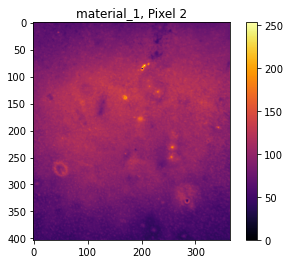

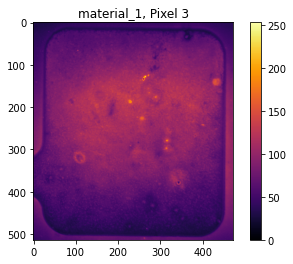

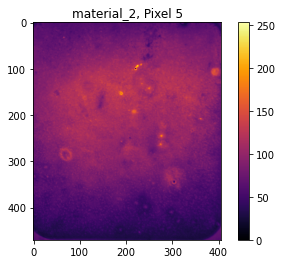

In [8]:
for i, key in enumerate(cell_borders.keys()):
    rmin = cell_borders[key][0]
    rmax = cell_borders[key][1]
    cmin = cell_borders[key][2]
    cmax = cell_borders[key][3]
    
    imarr = images_for_crop[i][rmin:rmax, cmin:cmax]
    
    plt.imshow(imarr,cmap="inferno")
    plt.colorbar()
    plt.title(names_of_crop[i])
    plt.show()

### STEP 3: Enter bandgaps
* We need bandgaps for the calculations
* Run bellow, enter as it prompts 

In [9]:
bandgaps = {}
for key in path_db.keys():
    if key.lower() != 'white':
        string = "What's the bandgap of "+key+" in eV?: "
        bandgap = float(input(string))
        bandgaps[key] = bandgap

What's the bandgap of material_1 in eV?: 1.6
What's the bandgap of material_2 in eV?: 1.6


### STEP 4: Enter Short circuit currents

In [10]:
jsc_db = {}
for key in path_db.keys(): 
    if key != 'white':
        jsc_db[key] = []
        for pix in path_db[key]:
            string = f"Enter Jsc for {key}, Pixel {pix}, in mA: "
            jsc_db[key].append(float(input(string))*1e-3)
            

Enter Jsc for material_1, Pixel 2, in mA: 17
Enter Jsc for material_1, Pixel 3, in mA: 17
Enter Jsc for material_2, Pixel 5, in mA: 17


### STEP 5: Calculate corrections

In [11]:
white_exposure = cam_exposure_puller(f"{datapath}\\white")

correction_db = {}
for key in path_db.keys(): 
    if key != 'white':
        bandgap = bandgaps[key]
        correction_db[key] = []
        for pix in path_db[key]:
            path = f"{datapath}\\{key}\\{pix}"
            cell_exposure = cam_exposure_puller(path)

            correction = white_over_cell_correction(white_exposure, cell_exposure, ledspecf, np.vectorize(BBf_cellf), 
                                                    bandgap, camqef, lenscalf, 0.99, filtcalf)

            correction_db[key].append(correction)

### STEP 6: JV curve for single pixel:

In [51]:
row,col = (1533,1843)
white_voltage = 2.55

for key in path_db.keys():  
    if key != 'white':
        bandgap = bandgaps[key]
        for i,pix in enumerate(path_db[key]):
            white_scale_factor = correction_db[key][i]
            jsc = jsc_db[key][i]
            voc_rad = vocradf(bandgap)
            
            path = f"{datapath}\\{key}\\{pix}"
            nominal_vs = GetNominalV(path)
            solar_scale_list = nominalV2sunscale(nominal_vs, bandgap, ledf)
            ref = averager(path+"\\camera\\refs", find_tif(path+"\\camera\\refs"))

            num_suns, rrs, Vs, Js = single_pixel_jv(f"{path}\\camera", row, col, jsc, voc_rad,
                                                    nominal_vs, solar_scale_list, white_cal, 
                                                    white, white_voltage, white_scale_factor, ref)